# Apple GAN

#### Select processing devices 

In [1]:
import os
os.environ['CUDA_DEVICE_ORDER'] = "PCI_BUS_ID"
os.environ['CUDA_VISIBLE_DEVICE'] = "1"

#### Load dependencies 

In [1]:
import numpy as np
import os

import keras
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Conv2D, BatchNormalization, Dropout, Flatten
from keras.layers import Activation, Reshape, UpSampling2D
from keras.layers.convolutional import Conv2DTranspose
from keras.optimizers import RMSprop

import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/__init__.py:962: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/__init__.py:962: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))


#### Load Data

In [2]:
input_images = "quickdraw_dataset/apple.npy"

In [3]:
data = np.load(input_images)
data.shape

(144722, 784)

In [4]:
data = data/255.
data = np.reshape(data, (-1, 28, 28, 1))
img_w, img_h = data.shape[1:3]
data.shape

(144722, 28, 28, 1)

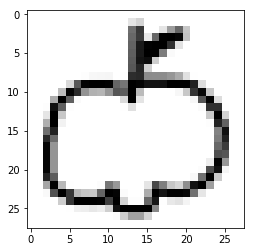

In [5]:
plt.imshow(data[4343, :,:, 0], cmap='Greys')

#### Create discrimanator network

In [6]:
def discriminator_builder(width=64, p=0.4):
    
    # define inputs
    inputs = Input((img_w, img_h, 1))
    
    # Fisrt Convolutional layer:
    conv1 = Conv2D(width*1, 5, strides=2, padding='same', activation='relu')(inputs)
    conv1 = Dropout(p)(conv1)
    
    # Second Convolutional layer:
    conv2 = Conv2D(width*2, 5, strides=2, padding='same', activation='relu')(conv1)
    conv2 = Dropout(p)(conv2)
    
    # Third Convolutional layer:
    conv3 = Conv2D(width*4, 5, strides=2, padding='same', activation='relu')(conv2)
    conv3 = Dropout(p)(conv3)
    
    # Fourth Convolutional layer:
    conv4 = Conv2D(width*8, 5, strides=1, padding='same', activation='relu')(conv3)
    conv4 = Flatten()(Dropout(p)(conv4))
    
    # output layer
    output = Dense(1, activation='sigmoid')(conv4)
    
    # model definition:
    model = Model(inputs=inputs, outputs=output)
    model.summary()
    
    return model

In [7]:
discriminator = discriminator_builder()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 64)        1664      
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 128)         204928    
_________________________________________________________________
dropout_2 (Dropout)          (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 4, 4, 256)         819456    
_________________________________________________________________
dropout_3 (Dropout)          (None, 4, 4, 256)         0         
__________

In [8]:
discriminator.compile(loss='binary_crossentropy',
                      optimizer=RMSprop(lr=0.0008, decay=6e-8, clipvalue=1),
                      metrics=['accuracy']) 

#### Create generator network

In [9]:
def generator_builder(z_dim=100, width=64, p=0.4):
    
    # define inputs
    inputs = Input((z_dim,))
    
    # First dense layer:
    dense1 = Dense(7*7*width)(inputs)
    dense1 = BatchNormalization(momentum=0.9)(dense1)
    dense1 = Activation(activation='relu')(dense1)
    dense1 = Reshape((7, 7, width))(dense1)
    dense1 = Dropout(p)(dense1)
    
    # First Deconvolutional layer:
    conv1 = UpSampling2D()(dense1)
    conv1 = Conv2DTranspose(int(width/2), kernel_size=5, padding='same', activation=None)(conv1)
    conv1 = BatchNormalization(momentum=0.9)(conv1)
    conv1 = Activation(activation='relu')(conv1)
    
    # Second Deconvolutional layer:
    conv2 = UpSampling2D()(conv1)
    conv2 = Conv2DTranspose(int(width/4), kernel_size=5, padding='same', activation=None)(conv2)
    conv2 = BatchNormalization(momentum=0.9)(conv2)
    conv2 = Activation(activation='relu')(conv2)
    
    # Third Deconvolutional layer:
    conv3 = Conv2DTranspose(int(width/8), kernel_size=5, padding='same', activation=None)(conv2)
    conv3 = BatchNormalization(momentum=0.9)(conv3)
    conv3 = Activation(activation='relu')(conv3)
    
    # output layer:
    output = Conv2D(1, kernel_size=5, padding='same', activation='sigmoid')(conv3)
    
    # model definition:
    model = Model(inputs=inputs, outputs=output)
    model.summary()
    
    return model
    

In [10]:
generator = generator_builder()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 3136)              316736    
_________________________________________________________________
batch_normalization_1 (Batch (None, 3136)              12544     
_________________________________________________________________
activation_1 (Activation)    (None, 3136)              0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 7, 7, 64)          0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 7, 7, 64)          0         
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 14, 14, 64)        0         
__________

#### Create Adversarial network

In [11]:
def adversarial_builder(z_dim=100):
    
    model = Sequential()
    model.add(generator)
    model.add(discriminator)
    
    model.compile(loss='binary_crossentropy',
                  optimizer= RMSprop(lr=0.0004, decay=3e-8, clipvalue=1.0),
                  metrics=['accuracy'])
    
    model.summary()
    
    return model

In [12]:
adversarial_model = adversarial_builder()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_2 (Model)              (None, 28, 28, 1)         396961    
_________________________________________________________________
model_1 (Model)              (None, 1)                 4311553   
Total params: 4,708,514
Trainable params: 4,702,130
Non-trainable params: 6,384
_________________________________________________________________


####  Train!

In [13]:
def make_trainable(net, val):
    net.trainable = val
    
    for l in net.layers:
        l.trainable = val

In [14]:
def train(epochs=2000, batch=128):
    
    d_metrics = []
    a_metrics = []
    
    running_d_loss = 0
    running_d_acc = 0
    running_a_loss = 0
    running_a_acc = 0
    
    for i in range(epochs):
        
        if i % 100 == 0:
            print(i)
        
        real_imgs = np.reshape(data[np.random.choice(data.shape[0], batch, replace=False)], (batch, 28, 28, 1))
        fake_imgs = generator.predict(np.random.uniform(-1.0, 1.0, size=[batch, 100]))

        x = np.concatenate((real_imgs, fake_imgs))
        
        y = np.ones([2*batch, 1])
        y[batch:, :] = 0
        
        make_trainable(discriminator, True)
        
        d_metrics.append(discriminator.train_on_batch(x, y))
        running_d_loss += d_metrics[-1][0]
        running_d_acc += d_metrics[-1][1]
        
        make_trainable(discriminator, False)
        
        noise = np.random.uniform(-1.0, 1.0, size=[batch, 100])
        y = np.ones([batch, 1])
        
        a_metrics.append(adversarial_model.train_on_batch(noise, y))
        running_a_loss += a_metrics[-1][0]
        running_a_acc += a_metrics[-1][1]
        
        if (i + 1) % 500 == 0:
            print('Epoch #{}'.format(i+1))
            log_mesg = "%d: [D loss: %f, acc: %f]" % (i, running_d_loss/i, running_d_acc/i)
            log_mesg = "%s  [A loss: %f, acc: %f]" % (log_mesg, running_a_loss/i, running_a_acc/i)
            print(log_mesg)

            noise = np.random.uniform(-1.0, 1.0, size=[16, 100])
            gen_imgs = generator.predict(noise)

            plt.figure(figsize=(5,5))

            for k in range(gen_imgs.shape[0]):
                plt.subplot(4, 4, k+1)
                plt.imshow(gen_imgs[k, :, :, 0], cmap='gray')
                plt.axis('off')
                
            plt.tight_layout()
            plt.show()
    
    return a_metrics, d_metrics
            

0


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/engine/training.py:973: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


100
200
300
400
Epoch #500
499: [D loss: 0.476197, acc: 0.765562]  [A loss: 1.898156, acc: 0.079628]


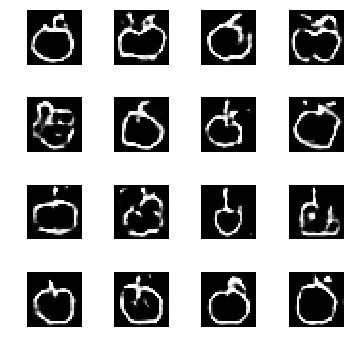

500
600
700
800
900
Epoch #1000
999: [D loss: 0.542971, acc: 0.718582]  [A loss: 1.556380, acc: 0.094227]


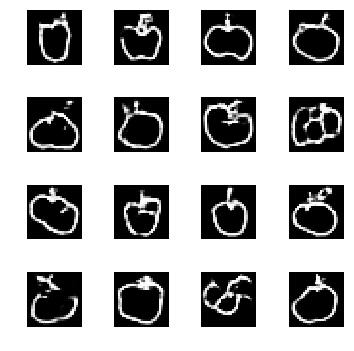

1000
1100
1200
1300
1400
Epoch #1500
1499: [D loss: 0.567949, acc: 0.704668]  [A loss: 1.516569, acc: 0.102438]


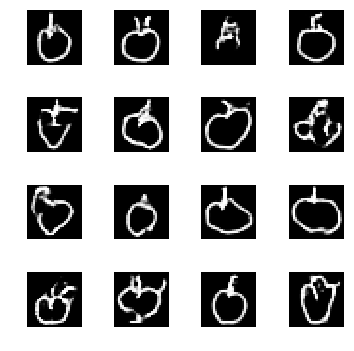

1500
1600
1700
1800
1900
Epoch #2000
1999: [D loss: 0.574602, acc: 0.703811]  [A loss: 1.555819, acc: 0.108203]


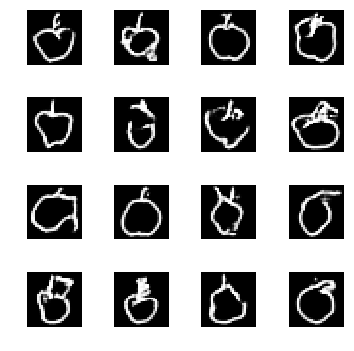

In [15]:
a_metrics_complete, d_metrics_complete = train()

Text(0,0.5,'Loss')

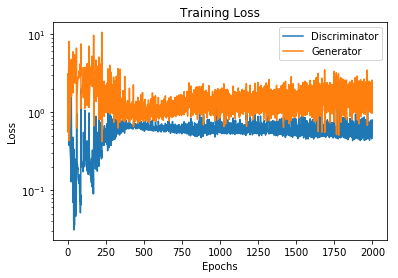

In [16]:
ax = pd.DataFrame(
    {
        'Generator': [metric[0] for metric in a_metrics_complete],
        'Discriminator': [metric[0] for metric in d_metrics_complete],
    }
).plot(title='Training Loss', logy=True)
ax.set_xlabel("Epochs")
ax.set_ylabel("Loss")

Text(0,0.5,'Accuracy')

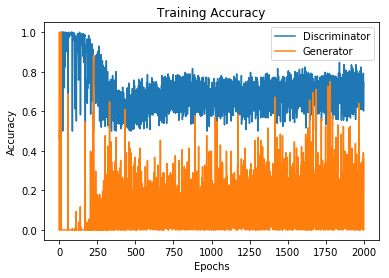

In [17]:
ax = pd.DataFrame(
    {
        'Generator': [metric[1] for metric in a_metrics_complete],
        'Discriminator': [metric[1] for metric in d_metrics_complete],
    }
).plot(title='Training Accuracy')
ax.set_xlabel("Epochs")
ax.set_ylabel("Accuracy")